In [ ]:
from autots import AutoTS, load_daily
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# sample datasets can be used in either of the long or wide import shapes
long = False
df = load_daily(long=long)

model = AutoTS(
    forecast_length=21,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='auto',
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model = model.fit(
    df,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric, series=model.df_wide_numeric.columns[0], start_date="2019-01-01")
# Print the details of the best model
print(model)

# point forecasts dataframe
forecasts_df = prediction.forecast
# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import dotenv_values
import numpy as np
import cx_Oracle
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

config = dotenv_values("../../../.env")

out_db_params = {
    'db_host': config["ORACLE_IP"],
    'db_name': config["ORACLE_DB"],
    'db_user': config["ORACLE_USER"],
    'db_password': config["ORACLE_PWD"],
    'db_port': config["ORACLE_PORT"]
}
print(config["LD_LIBRARY_PATH"])
cx_Oracle.init_oracle_client(lib_dir=config["LD_LIBRARY_PATH"])

/home/mfrancia/predict/intentional/libs/instantclient_21_1


/tmp/ipykernel_3656061/4066146017.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
engine = create_engine('oracle+cx_oracle://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'.format(**out_db_params))
query = "SELECT * FROM cimice_dt_time"
df = pd.read_sql(query, engine)
df

,timestamp,date,month,year,week,week_in_year
0,2020-04-01,01-APR-20,2020-4,2020,14,2020-14
1,2020-04-02,02-APR-20,2020-4,2020,14,2020-14
2,2020-04-03,03-APR-20,2020-4,2020,14,2020-14
3,2020-04-04,04-APR-20,2020-4,2020,14,2020-14
4,2020-04-05,05-APR-20,2020-4,2020,14,2020-14
...,...,...,...,...,...,...
938,2022-10-26,26-OCT-22,2022-10,2022,43,2022-43
939,2022-10-27,27-OCT-22,2022-10,2022,43,2022-43
940,2022-10-28,28-OCT-22,2022-10,2022,43,2022-43
941,2022-10-29,29-OCT-22,2022-10,2022,43,2022-43


Get the query

In [103]:
target_measure = "adults"
date_attr = "week"
column = "province"

# Replace 'your_table' with the actual table name
query = """
SELECT t.province, f.timestamp, sum(adults) as adults, sum(small_instars) as small_instars, sum(total_captures) as total_captures -- , sum(large_instars) as large_instars
FROM cimice_ft_captures f join cimice_dt_trap t on (t.gid = f.gid) right join cimice_dt_time d on (f.timestamp = d.timestamp)
-- WHERE (province = 'PR' or province = 'BO' or province = 'FC')
GROUP BY t.province, f.timestamp
"""

query = """
-- SELECT * FROM (
SELECT y.province, y.week, sum(adults) as adults, sum(small_instars) as small_instars, sum(total_captures) as total_captures -- , sum(large_instars) as large_instars
FROM cimice_ft_captures f right join (select * from (select * from cimice_dt_time where timestamp between TO_DATE('2021-05-01','YYYY-MM-DD') and TO_DATE('2021-11-30','YYYY-MM-DD')), cimice_dt_trap) y on (y.gid = f.gid and y.timestamp = f.timestamp)
-- WHERE (province = 'PR' or province = 'BO' or province = 'FC')
GROUP BY y.province, y.week
ORDER BY y.province, y.week
-- ) where adults is not null
"""

df = pd.read_sql(query, engine)
values = [x for x in df.columns if x not in [target_measure, date_attr]] 
# df[date_attr] = pd.to_datetime(df[date_attr], unit="s")
# df.set_index('timestamp', inplace=True)
# df.index = pd.DatetimeIndex(df.index).to_period('D')
df

,province,week,adults,small_instars,total_captures
0,BO,17,NaN,NaN,NaN
1,BO,18,55.0,0.0,55.0
2,BO,19,55.0,0.0,55.0
3,BO,20,70.0,0.0,70.0
4,BO,21,65.0,0.0,65.0
...,...,...,...,...,...
251,RE,44,NaN,NaN,NaN
252,RE,45,NaN,NaN,NaN
253,RE,46,NaN,NaN,NaN
254,RE,47,NaN,NaN,NaN


Decision tree (without time handled separatedly)

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random
import warnings
warnings.filterwarnings('ignore')

seed=42
test_size=0.2

def compute_model(df, target_column, model, seed=seed, test_size=test_size):
    # One-hot encode object columns
    object_columns = list(df.select_dtypes(include=['object']).columns)
    df_enc = df
    if len(object_columns) > 0:
        df_enc = pd.get_dummies(df, drop_first=True, dtype=float, prefix_sep="!")
    # Convert data columns to float
    datetime_columns = list(df_enc.select_dtypes(include=['datetime64']).columns)
    if len(datetime_columns) > 0:
        df_enc[datetime_columns] = df_enc[datetime_columns].astype(int) / 10**9 # Convert to seconds as float
    
    # Create a separate dataframe for rows with missing values in the target column
    missing_values_df = df_enc[df_enc[target_column].isnull()]
    df_enc = df_enc.dropna(subset=[target_column])

    # Separate target variable (what you want to predict) from features
    X = df_enc.drop(target_column, axis=1)
    y = df_enc[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, shuffle=False)
    model.fit(X_train, y_train)
    # Get the best parameters and the best model
    # best_params = grid_search.best_params_
    # best_dt_reg = grid_search.best_estimator_
    # print('Best Hyperparameters:', best_params)
    y_pred = model.predict(X_test)
    value = r2_score(y_test, y_pred)    

    # Fill in missing values in the original dataframe
    missing_values_df[target_column] = model.predict(missing_values_df.drop(target_column, axis=1))
    df.loc[df[target_column].isnull(), target_column] = missing_values_df[target_column]

    return df, df[target_column], X_train, y_train, X_test, y_test, y_pred, missing_values_df, value

def dtree(df, target_column, date_attr=None, seed=seed, test_size=test_size):
    # Define the hyperparameters you want to search through
    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [seed] 
    }
    # Use GridSearchCV to find the best hyperparameters
    model = RandomizedSearchCV(DecisionTreeRegressor(random_state=seed), param_grid, n_iter=10, cv=5, scoring='r2', random_state=seed)
    return compute_model(df, target_column, model)

ndf = pd.read_sql(query, engine).copy(deep=True)
# Define the percentage of NaN values to add randomly
# nan_percentage = 0.1
# Calculate the number of NaN values to add
# num_nan_to_add = int(nan_percentage * ndf.shape[0])
# Randomly select indices to add NaN values
# nan_indices = np.random.choice(ndf.index, num_nan_to_add, replace=False)
# Set NaN values in the specified column
# ndf.loc[nan_indices, target_measure] = np.nan
X, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = dtree(ndf, target_measure)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   province        256 non-null    object 
 1   week            256 non-null    int64  
 2   adults          256 non-null    float64
 3   small_instars   196 non-null    float64
 4   total_captures  196 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 10.1+ KB


In [111]:
def mypivot(df, date_attr, column, exog, target_measure, impute=False):
    df = df.pivot_table(index=date_attr, columns=[column], values=exog, dropna=False)#, aggfunc='sum' , fill_value=-1
    df.columns = [f'{col[0]}!{col[1]}' if col[1] else col[0] for col in df.columns]
    # if impute:
    #    for x in [x for x in df.columns if "!" in x and target_measure not in x]:
    #        df[x] = df[x].fillna(df[x].median())
    return df[[x for x in df.columns if "index" not in x]]  

pdf = mypivot(df.copy(deep=True), date_attr, column, values, target_measure, impute=False).reset_index()# .dropna()
# pdf.info()
# def nans(df): return df[[x for x in df.columns if df[x].isnull().any()]]
# nans(pdf)
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               32 non-null     int64  
 1   adults!BO          24 non-null     float64
 2   adults!FC          24 non-null     float64
 3   adults!FE          24 non-null     float64
 4   adults!MO          25 non-null     float64
 5   adults!PC          25 non-null     float64
 6   adults!PR          25 non-null     float64
 7   adults!RA          24 non-null     float64
 8   adults!RE          25 non-null     float64
 9   small_instars!BO   24 non-null     float64
 10  small_instars!FC   24 non-null     float64
 11  small_instars!FE   24 non-null     float64
 12  small_instars!MO   25 non-null     float64
 13  small_instars!PC   25 non-null     float64
 14  small_instars!PR   25 non-null     float64
 15  small_instars!RA   24 non-null     float64
 16  small_instars!RE   25 non-nu

In [112]:
pdf

,week,adults!BO,adults!FC,adults!FE,adults!MO,adults!PC,adults!PR,adults!RA,adults!RE,small_instars!BO,...,small_instars!RA,small_instars!RE,total_captures!BO,total_captures!FC,total_captures!FE,total_captures!MO,total_captures!PC,total_captures!PR,total_captures!RA,total_captures!RE
0,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18,55.000000,112.000000,192.000000,121.000000,7.0,1.285714,144.111111,8.0,0.0,...,0.000000,0.0,55.000000,112.000000,192.000000,121.000000,7.0,1.285714,144.111111,8.0
2,19,55.000000,69.000000,150.400000,135.000000,43.0,1.000000,208.388889,34.0,0.0,...,0.000000,0.0,55.000000,69.000000,150.400000,135.000000,43.0,1.000000,208.388889,34.0
3,20,70.000000,71.000000,243.329762,199.133333,21.0,0.000000,198.571429,12.0,0.0,...,0.000000,0.0,70.000000,71.000000,243.329762,199.133333,21.0,0.000000,198.571429,12.0
4,21,65.000000,112.000000,240.751299,218.866667,7.0,0.000000,360.890476,60.0,0.0,...,0.000000,0.0,65.000000,112.000000,240.751299,223.866667,7.0,0.000000,360.890476,60.0
5,22,57.000000,44.000000,208.301357,204.000000,13.0,4.000000,402.038095,49.0,0.0,...,0.000000,0.0,57.000000,44.000000,209.158500,204.000000,13.0,4.000000,402.038095,49.0
6,23,74.000000,60.000000,256.839011,173.000000,27.0,5.000000,288.785714,46.0,0.0,...,4.000000,0.0,74.000000,60.000000,258.039011,176.000000,27.0,5.000000,292.785714,46.0
7,24,71.000000,40.500000,81.550000,127.000000,2.0,2.000000,251.814286,36.0,5.0,...,51.666667,8.0,76.000000,60.000000,223.750000,241.000000,2.0,6.000000,303.480952,44.0
8,25,53.000000,40.500000,107.800000,65.000000,7.0,0.000000,229.400000,29.0,152.0,...,699.066667,56.0,206.000000,152.000000,441.000000,559.000000,13.0,0.000000,935.466667,92.0
9,26,34.000000,27.000000,125.210390,45.000000,5.0,4.000000,180.230769,26.0,277.0,...,698.420513,88.0,325.000000,125.000000,608.025974,748.000000,5.0,7.000000,907.651282,131.0


ts(adults!BO)
ts(adults!FC)
ts(adults!FE)
ts(adults!MO)
ts(adults!PC)
ts(adults!PR)
ts(adults!RA)
ts(adults!RE)


,week,province,adults
0,17,BO,67.5
1,18,BO,55.0
2,19,BO,55.0
3,20,BO,70.0
4,21,BO,65.0
...,...,...,...
251,44,RE,74.5
252,45,RE,74.5
253,46,RE,74.5
254,47,RE,74.5


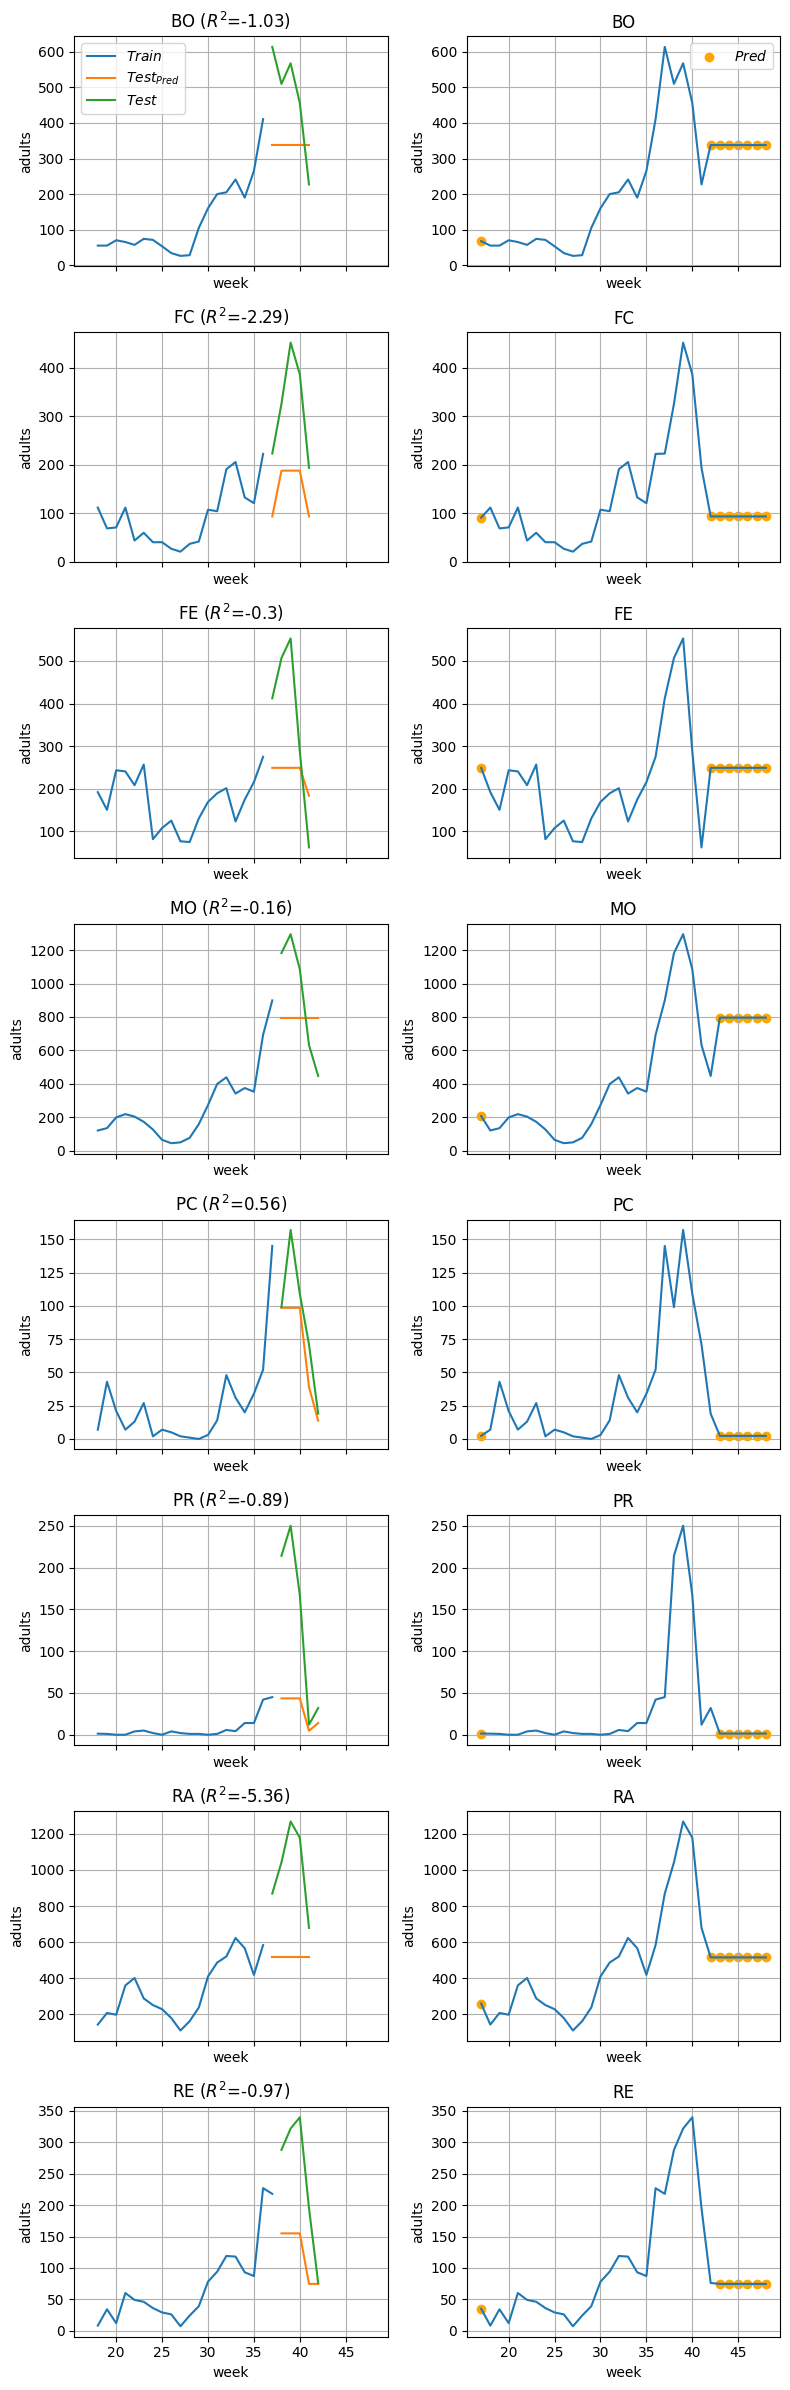

In [117]:
def timeseries(df, date_attr, column, target_measure, model):
    targets = [x for x in df.columns if "!" in x and target_measure in x]
    actual_targets = [c for c in targets if df[c].isnull().any()]

    # num_cols = 3
    # num_rows = len(actual_targets) // num_cols + (len(actual_targets) % num_cols > 0)
    # Create a figure and subplots
    # fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))
    fig, axs = plt.subplots(len(actual_targets), 2, figsize=(8, 3*len(actual_targets)), sharex=True, sharey=False)
    # Flatten the axs array if it's a multi-dimensional array
    axs = axs.flatten()
    i = 0
    for c in actual_targets:
        print(f"ts({c})")
        # drop the wrong target measures 
        cdf = df.drop(columns=[x for x in targets if x != c], axis=1)
        # drop the wrong slices 
        cdf = df.drop(columns=[x for x in df.columns if "!" in x and c.split("!")[1] not in x], axis=1)
        cdf = cdf.sort_values(by=[date_attr])
        cdf, y, X_train, y_train, X_test, y_test, y_pred, missing_values_df, value = model(cdf, c, date_attr=date_attr)
        df[c] = cdf[c]

        axs[i].plot(X_train[date_attr], y_train, label="$Train$")
        if y_pred is not None:
            axs[i].plot(X_test[date_attr], y_pred, label="$Test_{Pred}$")
        axs[i].plot(X_test[date_attr], y_test, label="$Test$")
        
        axs[i + 1].plot(cdf[date_attr], y)
        axs[i + 1].scatter(missing_values_df[date_attr], missing_values_df[c], label="$Pred$", c='orange')

        for j in range(2):
            title = f'{c.split("!")[1]}' + (f' ($R^2$={round(value, 2)})' if j == 0 else '')
            axs[i + j].set_title(title)
            axs[i + j].set_xlabel(date_attr)
            axs[i + j].set_ylabel(f'{c.split("!")[0]}')
            axs[i + j].grid()
            if i == 0:
                axs[i + j].legend()
            
        i += 2
    fig.tight_layout()
    fig.savefig(f"{c}.svg")
    adf = df[[x for x in df.columns if "!" not in x or target_measure in x]]
    adf = pd.melt(adf, id_vars=date_attr, value_vars=[x for x in pdf.columns if target_measure in x], var_name=column, value_name=target_measure)
    adf[column] = adf[column].apply(lambda x: x.replace(f"{target_measure}!", ""))
    return adf


adf = timeseries(pdf.copy(deep=True), date_attr, column, target_measure, dtree)
adf


ts(adults!BO)
Provided exogenous values are not of the appropriate shape. Required (8, 2), got (32, 2).
ts(adults!FC)
Provided exogenous values are not of the appropriate shape. Required (8, 2), got (32, 2).
ts(adults!FE)
Provided exogenous values are not of the appropriate shape. Required (8, 2), got (32, 2).
ts(adults!MO)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
ts(adults!PC)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
ts(adults!PR)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
ts(adults!RA)
Provided exogenous values are not of the appropriate shape. Required (8, 2), got (32, 2).
ts(adults!RE)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 d

,week,province,adults
0,17,BO,NaN
1,18,BO,55.0
2,19,BO,55.0
3,20,BO,70.0
4,21,BO,65.0
...,...,...,...
251,44,RE,NaN
252,45,RE,NaN
253,46,RE,NaN
254,47,RE,NaN


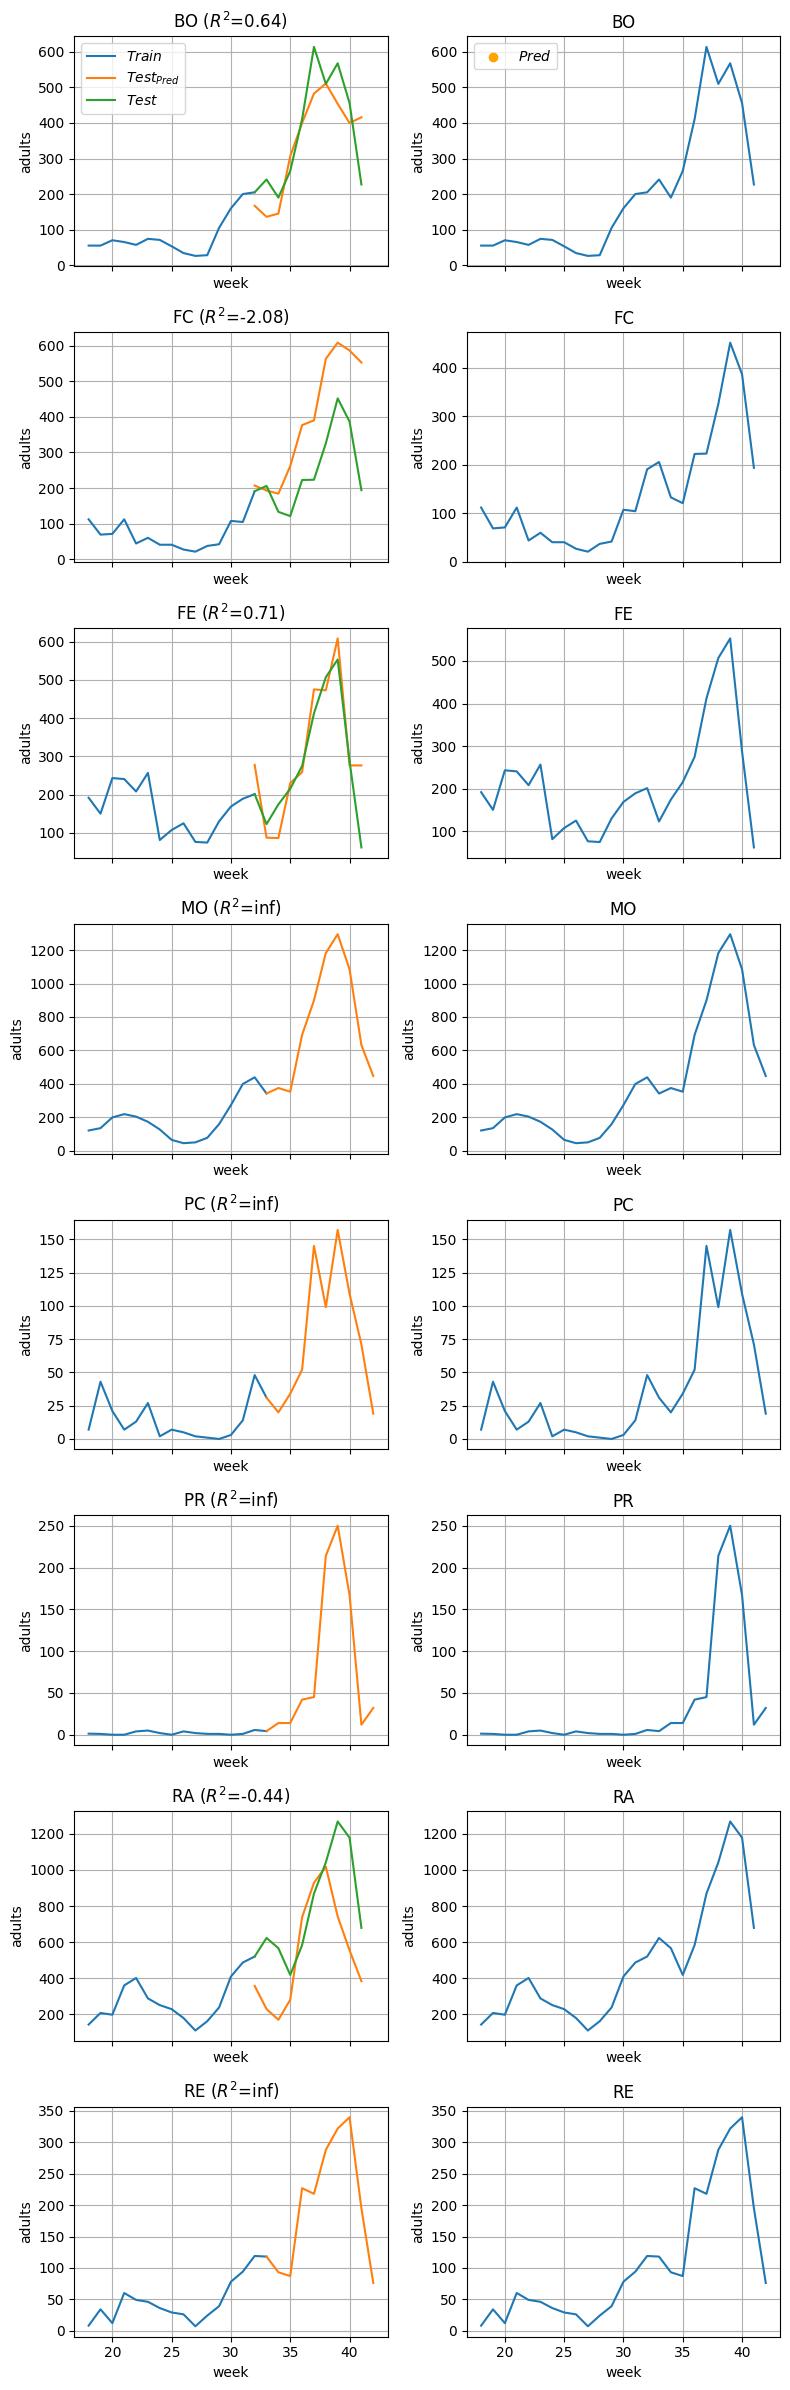

In [118]:
def sarimax(df, target_measure, date_attr, forecast_steps=10):
    # Create a separate dataframe for rows with missing values in the target column
    # df.set_index("timestamp", inplace=True)
    mydf = df
    missing_values_df = mydf[mydf[target_measure].isna()]
    missing_indices = missing_values_df.index
    df = df.dropna()
    # if "PR" in target_measure:
    #     print(df.info())
    exog = [x for x in df.columns if target_measure.split("!")[0] not in x and x != date_attr] + [date_attr] 
    # print(exog)
    # df_enc = df_enc.dropna(subset=[target_column])
    X_train, y_train, X_test, y_test = df[exog][:-forecast_steps+1], df[target_measure][:-forecast_steps+1], df[exog][-forecast_steps:], df[target_measure][-forecast_steps:]
    y_pred = None
    random.seed(seed)
    param_space = {
        'p1': [1, 2, 3],
        'p2': [1, 2, 3],
        'p3': [1, 2, 3],
        'p4': [1, 2, 3],
        'p5': [1, 2, 3],
        'p6': [1, 2, 3],
        'p7': [7, 12],
    }
    num_configs = 1
    
    best_metric = float('inf')  # For minimization tasks, use 'inf' for maximization
    try:
        for _ in range(num_configs):
            # Generate a random set of hyperparameters
            chp = {param: random.choice(values) for param, values in param_space.items()}
            # Train and evaluate the model with the current set of hyperparameters
            order = (chp["p1"] , chp["p2"], chp["p3"]) # to tune 
            seasonal_order = (chp["p4"], chp["p5"], chp["p6"], chp["p7"]) # to tune
            # try:
            if len(exog) == 0:
                model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
            else:
                model = SARIMAX(endog=y_train, exog=X_train.drop(date_attr, axis=1), order=order, seasonal_order=seasonal_order)
            results = model.fit(disp=False)
            if len(exog) == 0:
                fcst = results.get_forecast(steps=forecast_steps)
            else:
                fcst = results.get_forecast(steps=forecast_steps, exog=X_test.drop(date_attr, axis=1))
                # fcst = results.get_prediction(start=df.idxmin(), end=df.idxmax(), exog=df[exog]) 
            y_pred = fcst.predicted_mean
            y_pred.index = y_test.index
            current_metric = r2_score(y_test, y_pred)
            # Update the best hyperparameters if the current configuration is better
            if current_metric < best_metric:
                best_metric = current_metric
                best_hyperparameters = chp
                best_forecast = y_pred
                best_fcts = fcst
                best_model = results
            # except Exception as e:
            #     print(e)
        
        # print("Best")
        # Make predictions for the missing values
        # print(missing_indices)
        chp = best_hyperparameters
        order = (chp["p1"], chp["p2"], chp["p3"]) # to tune 
        seasonal_order = (chp["p4"], chp["p5"], chp["p6"], chp["p7"]) # to tune
        model = SARIMAX(endog=df[target_measure], exog=df[exog].drop(date_attr, axis=1), order=order, seasonal_order=seasonal_order)
    
        results = model.fit(disp=False)
        # print("Predicting")
        # mydf[exog].loc[missing_indices[0]:missing_indices[-1]].to_csv(target_measure + ".csv")
        forecast = results.get_prediction(start=missing_indices[0], end=missing_indices[-1], exog=mydf[exog].drop(date_attr, axis=1).loc[missing_indices[0]:missing_indices[-1]]).predicted_mean
        forecast.index = mydf.loc[missing_indices[0]:missing_indices[-1]].index
        # forecast = results.get_prediction(start=mydf.index.min(), end=mydf.index.max(), exog=mydf[exog]).predicted_mean
        missing_values_df[target_measure] = forecast
        mydf.loc[mydf[target_measure].isnull(), target_measure] = forecast
    except Exception as e:
        # print(missing_indices[0])
        # print(missing_indices[-1])
        # print(len(mydf))
        print(e)
        
    # print("Done")
    return mydf, mydf[target_measure], X_train, y_train, X_test, y_test, y_pred, missing_values_df, best_metric

    plt.plot(train.index.to_timestamp(), train, label='Train')
    plt.plot(test.index.to_timestamp(), test, label='Test')
    plt.plot(forecast.index.to_timestamp(), forecast, label='Forecast')
    plt.fill_between(
        forecast.index.to_timestamp(),
        fcst.conf_int()[f'lower {c}'],
        fcst.conf_int()[f'upper {c}'],
        color='pink',
        alpha=0.5,
        label='Confidence Interval'
    )
    plt.grid()
    plt.legend()
    plt.xticks(rotation=70)
    summary = results.summary()
    return summary

adf = timeseries(pdf.copy(deep=True), date_attr, column, target_measure, sarimax)
adf